<a href="https://colab.research.google.com/github/weskhoo/LA-urban-trees/blob/main/LA_Trees_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# All required modules


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np


import argparse
from pathlib import Path

!pip install geopandas
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

import time
import requests
from bs4 import BeautifulSoup

#ty: https://geopandas.readthedocs.io/en/latest/gallery/create_geopandas_from_pandas.html#from-wkt-format
from shapely import wkt

!pip3 install contextily
import contextily as ctx

     |████████████████████████████████| 972kB 2.8MB/s 
     |████████████████████████████████| 6.5MB 14.3MB/s 
     |████████████████████████████████| 14.8MB 304kB/s 
     |████████████████████████████████| 18.3MB 1.3MB/s 


# Scrape from github

In [ ]:
page = requests.get(f'https://github.com/stiles/data/tree/master/los-angeles-street-trees/all')
soup = BeautifulSoup(page.content, 'html.parser')

container = soup.find(id="js-repo-pjax-container")

title_tag = container.select("[title]")
titles = [pt.get_text() for pt in title_tag]
titles = titles[8:]
titles.remove("script.sh")
titles.remove("pasadena.geojson")
print(len(titles)) #should give 49

49


In [ ]:
tic = time.perf_counter()
citiesdf = pd.DataFrame()
problems = []
for title in titles:
  url = f"https://github.com/stiles/data/blob/master/los-angeles-street-trees/all/{title}?raw=True"
  onecitydf = gpd.read_file(url)
  onecitydf["whichcity"] = title
  onecitydf.columns = onecitydf.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
  if 'lat' in onecitydf.columns:
    onecitydf = onecitydf.drop('lat',axis=1)
  if 'lon' in onecitydf.columns:
    onecitydf = onecitydf.drop('lon',axis=1)
  if 'objectid' in onecitydf.columns:
    onecitydf = onecitydf.drop('objectid',axis=1)
  citiesdf = citiesdf.append(onecitydf)
  print(f"Done with {title}")

toc = time.perf_counter()
print(f"Completed scraping all trees from Stiles Github in {toc - tic:0.4f} seconds.")

Done with agoura-hills.geojson
Done with alhambra.geojson
Done with arcadia.geojson
Done with artesia.geojson
Done with bell-gardens.geojson
Done with bellflower.geojson
Done with beverly-hills.geojson
Done with burbank.geojson
Done with carson.geojson
Done with cerritos.geojson
Done with covina.geojson
Done with culver-city.geojson
Done with diamond-bar.geojson
Done with downey.geojson
Done with duarte.geojson
Done with el-monte.geojson
Done with el-segundo.geojson
Done with glendale.geojson
Done with glendora.geojson
Done with inglewood.geojson
Done with la-mirada.geojson
Done with la-verne.geojson
Done with lancaster.geojson
Done with lawndale.geojson
Done with lomita.geojson
Done with long-beach.geojson
Done with los-angeles-city.geojson
Done with los-angeles-county.geojson
Done with malibu.geojson
Done with mandarin-orange-trees.geojson
Done with paramount.geojson
Done with pomona.geojson
Done with rancho-palos-verdes.geojson
Done with redondo-beach.geojson
Done with san-dimas.geo

In [ ]:
url = 'https://github.com/stiles/data/blob/master/los-angeles-street-trees/all/pasadena.geojson?raw=True'
pasadena = gpd.read_file(url)

#cleaning the columns
pasadena["botanical"] = pasadena["Genus"] + " " + pasadena["Species"]
pasadena = pasadena.drop(['Genus','Species'],axis=1)

pasadena["whichcity"] = "pasadena.geojson"
pasadena.columns = pasadena.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
if 'lat' in pasadena.columns:
  pasadena = pasadena.drop('lat',axis=1)
if 'lon' in pasadena.columns:
  pasadena = pasadena.drop('lon',axis=1)
if 'objectid' in pasadena.columns:
  pasadena = pasadena.drop('objectid',axis=1)

In [ ]:
#appending pasadena to main df
treesdf = citiesdf.append(pasadena)

def removegeojson(str1):
  return str1.replace(".geojson","")

#cleaning the main df
treesdf = treesdf.drop('city',axis=1)
treesdf['city'] = treesdf['whichcity'].apply(removegeojson)
treesdf = treesdf.drop('whichcity',axis=1)

In [ ]:
treesdf.info(verbose=True, null_counts=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1673610 entries, 0 to 71131
Data columns (total 225 columns):
 #   Column               Non-Null Count    Dtype   
---  ------               --------------    -----   
 0   inventoryid          139884 non-null   float64 
 1   district             267675 non-null   object  
 2   address              668706 non-null   float64 
 3   fictitious           192187 non-null   object  
 4   street               527881 non-null   object  
 5   sidetype             258325 non-null   object  
 6   tree                 430634 non-null   float64 
 7   onaddress            278577 non-null   float64 
 8   onstreet             287995 non-null   object  
 9   species              1519523 non-null  object  
 10  botanical            469450 non-null   object  
 11  dbh                  575187 non-null   object  
 12  height               736006 non-null   object  
 13  parkwaytype          105215 non-null   object  
 14  geometry             167361

In [ ]:
treesdf['city'].value_counts()

los-angeles-city         540668
long-beach               140822
santa-clarita            112453
los-angeles-county        96053
pasadena                  71132
glendale                  56816
pomona                    50513
lancaster                 46763
santa-monica              35235
cerritos                  31331
whittier                  27898
beverly-hills             26955
carson                    22585
inglewood                 21858
south-gate                20928
diamond-bar               20147
alhambra                  20121
downey                    18544
la-mirada                 17021
culver-city               16986
santa-clarita-parks       16583
simi-valley               16459
arcadia                   15684
covina                    14697
redondo-beach             13609
rancho-palos-verdes       13584
glendora                  12656
el-monte                  11617
south-pasadena            11349
la-verne                  11109
san-dimas                 10538
san-gabr

In [ ]:
treesdf = treesdf.dropna(how='all', axis=1)

In [ ]:
treesdf.info(verbose=True, null_counts=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1673610 entries, 0 to 71131
Data columns (total 188 columns):
 #   Column               Non-Null Count    Dtype   
---  ------               --------------    -----   
 0   inventoryid          139884 non-null   float64 
 1   district             267675 non-null   object  
 2   address              668706 non-null   float64 
 3   fictitious           192187 non-null   object  
 4   street               527881 non-null   object  
 5   sidetype             258325 non-null   object  
 6   tree                 430634 non-null   float64 
 7   onaddress            278577 non-null   float64 
 8   onstreet             287995 non-null   object  
 9   species              1519523 non-null  object  
 10  botanical            469450 non-null   object  
 11  dbh                  575187 non-null   object  
 12  height               736006 non-null   object  
 13  parkwaytype          105215 non-null   object  
 14  geometry             167361

Mounted at /content/drive


In [ ]:
treesdf.to_csv('LAtrees.csv')
!cp LAtrees.csv "/content/drive/My Drive/Public Trees - Wes/"

# Analyzing trees

In [3]:
path = '/content/drive/My Drive/Public Trees - Wes/LAtrees.csv'
trees = pd.read_csv(path)
finalcols = ["city","geometry","species","height","dbh","street","botanical","botanicaln"]
trees = trees[finalcols]
trees["species"] = trees["species"].str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
trees.info()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,4,5,6,9,10,11,12,13,14,16,17,18,19,20,22,24,26,27,32,34,35,36,37,38,39,42,43,44,45,50,51,53,55,56,58,60,61,62,63,64,65,66,67,68,69,70,71,74,75,76,80,81,82,84,85,86,87,88,89,90,92,93,94,97,100,101,104,105,107,108,110,111,112,113,115,121,122,123,125,126,130,131,133,135,137,138,145,147,149,150,151,153,155,156,157,159,164,169,170,171,172,173,174,175,176,177,178,179,181,182,184,185,186) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1673610 entries, 0 to 1673609
Data columns (total 8 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   city        1673610 non-null  object
 1   geometry    1673610 non-null  object
 2   species     1519245 non-null  object
 3   height      723143 non-null   object
 4   dbh         562566 non-null   object
 5   street      527881 non-null   object
 6   botanical   469450 non-null   object
 7   botanicaln  358435 non-null   object
dtypes: object(8)
memory usage: 102.1+ MB


In [4]:
"""
To sort column names according to non_null values

column_names = list(trees.columns)
non_null_values = []

for i in columns:
  non_null_values.append(trees[f"{i}"].count())

columndf = pd.DataFrame({"column":column_names,"pop":non_null_values})

columndf = columndf.sort_values(by=['pop'], ascending=False)
"""

'\nTo sort column names according to non_null values\n\ncolumn_names = list(trees.columns)\nnon_null_values = []\n\nfor i in columns:\n  non_null_values.append(trees[f"{i}"].count())\n\ncolumndf = pd.DataFrame({"column":column_names,"pop":non_null_values})\n\ncolumndf = columndf.sort_values(by=[\'pop\'], ascending=False)\n'

In [5]:
#removing species that contains 'vacant'
vacant_df = trees[(trees["species"] == 'vacant') | (trees["species"] == 'vacant_site')]
clean_trees = trees.drop(vacant_df.index, axis=0)
clean_trees["species"].value_counts()

crape_myrtle             88385
mexican_fan_palm         64561
southern_magnolia        61801
american_sweetgum        58465
jacaranda                42295
                         ...  
litchi                       1
paradise_apple               1
zadd_28                      1
tiger-claw_coral_tree        1
philodendron_selloum         1
Name: species, Length: 1497, dtype: int64

In [6]:
#ty: https://geopandas.readthedocs.io/en/latest/gallery/create_geopandas_from_pandas.html#from-wkt-format
from shapely import wkt

clean_trees['geometry'] = clean_trees['geometry'].apply(wkt.loads)
clean_trees.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1485869 entries, 0 to 1673609
Data columns (total 8 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   city        1485869 non-null  object
 1   geometry    1485869 non-null  object
 2   species     1331504 non-null  object
 3   height      604274 non-null   object
 4   dbh         490649 non-null   object
 5   street      445619 non-null   object
 6   botanical   432015 non-null   object
 7   botanicaln  272541 non-null   object
dtypes: object(8)
memory usage: 102.0+ MB


In [7]:
path = '/content/drive/My Drive/Public Trees - Wes/propercitytrees.csv'
goodcities = pd.read_csv(path)

goodcities_list = []

for i,j in zip(goodcities["ok"],goodcities["Unnamed: 0"]):
  if i == 'y':
    goodcities_list.append(j)
goodtrees = clean_trees.query("city in @goodcities_list")
goodtrees.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1120493 entries, 40923 to 1673609
Data columns (total 8 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   city        1120493 non-null  object
 1   geometry    1120493 non-null  object
 2   species     1086694 non-null  object
 3   height      398555 non-null   object
 4   dbh         284542 non-null   object
 5   street      312007 non-null   object
 6   botanical   241155 non-null   object
 7   botanicaln  218649 non-null   object
dtypes: object(8)
memory usage: 76.9+ MB


In [8]:
minus118_list = []
for i,j in zip(goodcities["-118"],goodcities["Unnamed: 0"]):
  if i == 'y':
    minus118_list.append(j)
minus118_trees = clean_trees.query("city in @minus118_list")
geo_minus118 = gpd.GeoDataFrame(minus118_trees, geometry='geometry')

geo_minus118['lon'] = geo_minus118['geometry'].x
geo_minus118['lat'] = geo_minus118['geometry'].y

#remove geometry that is out of range in error
geo_minus118 = geo_minus118[geo_minus118["lon"]<-117]
geo_minus118.head()

,city,geometry,species,height,dbh,street,botanical,botanicaln,lon,lat
0,agoura-hills,POINT (-118.72476 34.13622),coast_live_oak,01-15,0-6,AGOURA RD,Quercus agrifolia,NaN,-118.724759,34.136224
1,agoura-hills,POINT (-118.72499 34.13624),coast_live_oak,01-15,0-6,AGOURA RD,Quercus agrifolia,NaN,-118.724987,34.136245
2,agoura-hills,POINT (-118.72513 34.13621),coast_live_oak,15-30,07-12,AGOURA RD,Quercus agrifolia,NaN,-118.725128,34.136208
3,agoura-hills,POINT (-118.72530 34.13617),coast_live_oak,01-15,07-12,AGOURA RD,Quercus agrifolia,NaN,-118.725300,34.136173
4,agoura-hills,POINT (-118.72545 34.13615),coast_live_oak,01-15,0-6,AGOURA RD,Quercus agrifolia,NaN,-118.725446,34.136147


In [9]:
e6_list = []
for i,j in zip(goodcities["1.00E+06"],goodcities["Unnamed: 0"]):
  if i == 'y':
    e6_list.append(j)
e6_trees = clean_trees.query("city in @e6_list")
geo_e6_trees = gpd.GeoDataFrame(e6_trees, geometry='geometry')

#use .crs to check crs of original shapefile

geo_e6_trees.set_crs(epsg=2229 , inplace=True)
geo_e6_trees["geometry"] = geo_e6_trees["geometry"].to_crs("EPSG:4326")
geo_e6_trees.head()

,city,geometry,species,height,dbh,street,botanical,botanicaln
25239,arcadia,POINT (-118.03557 34.11178),NaN,NaN,NaN,NaN,NaN,NaN
25240,arcadia,POINT (-118.03558 34.11232),NaN,NaN,NaN,NaN,NaN,NaN
25241,arcadia,POINT (-118.03559 34.11215),NaN,NaN,NaN,NaN,NaN,NaN
25242,arcadia,POINT (-118.03559 34.11191),NaN,NaN,NaN,NaN,NaN,NaN
25243,arcadia,POINT (-118.02596 34.12633),NaN,NaN,NaN,NaN,NaN,NaN


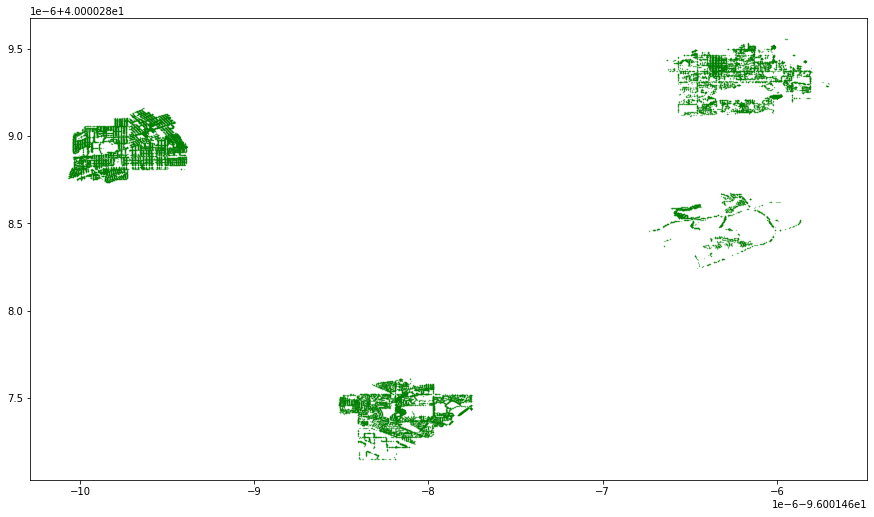

In [10]:
minus95_list = []
for i,j in zip(goodcities["-95"],goodcities["Unnamed: 0"]):
  if i == 'y':
    minus95_list.append(j)
minus95_trees = clean_trees.query("city in @minus95_list")

geo_minus95_trees = gpd.GeoDataFrame(minus95_trees, geometry='geometry')
ax2 = geo_minus95_trees.plot(figsize=(15, 15), color='green',alpha=0.5, markersize=0.1)

In [11]:
geo_minus95_trees.set_crs(epsg=4269 , inplace=True)
print(geo_minus95_trees.tail())
geo_minus95_trees["geometry"] = geo_minus95_trees["geometry"].to_crs("EPSG:4326")
geo_minus95_trees.tail()

           city                    geometry  ... botanical          botanicaln
1565508  walnut  POINT (-96.00147 40.00029)  ...       NaN  Prunus caroliniana
1565510  walnut  POINT (-96.00147 40.00029)  ...       NaN  Prunus caroliniana
1565511  walnut  POINT (-96.00147 40.00029)  ...       NaN  Prunus caroliniana
1565512  walnut  POINT (-96.00147 40.00029)  ...       NaN        Tipuana tipu
1565513  walnut  POINT (-96.00147 40.00029)  ...       NaN       Schinus molle

[5 rows x 8 columns]


,city,geometry,species,height,dbh,street,botanical,botanicaln
1565508,walnut,POINT (-96.00147 40.00029),carolina_laurel_cherry,01-15,0-6,WHISPERING HOLLOW CT,NaN,Prunus caroliniana
1565510,walnut,POINT (-96.00147 40.00029),carolina_laurel_cherry,01-15,0-6,WHISPERING HOLLOW CT,NaN,Prunus caroliniana
1565511,walnut,POINT (-96.00147 40.00029),carolina_laurel_cherry,01-15,0-6,WHISPERING HOLLOW CT,NaN,Prunus caroliniana
1565512,walnut,POINT (-96.00147 40.00029),tipu,30-45,19-24,WILDCAT CANYON RD,NaN,Tipuana tipu
1565513,walnut,POINT (-96.00147 40.00029),california_pepper,01-15,0-6,WILDCAT CANYON RD,NaN,Schinus molle


In [12]:
geo_minus95_trees["city"].value_counts()

alhambra     20121
la-mirada    14123
glendora     12656
walnut        2906
Name: city, dtype: int64

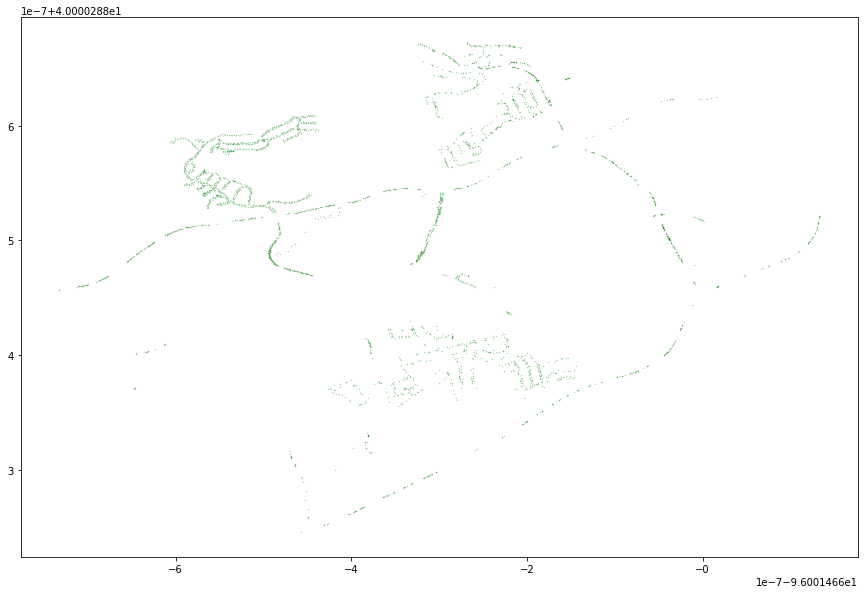

In [13]:
ax2 = geo_minus95_trees[geo_minus95_trees["city"]=="walnut"].plot(figsize=(15, 15), color='green',alpha=0.5, markersize=0.1)

In [14]:
geo_goodtrees = gpd.GeoDataFrame(goodtrees, geometry='geometry')

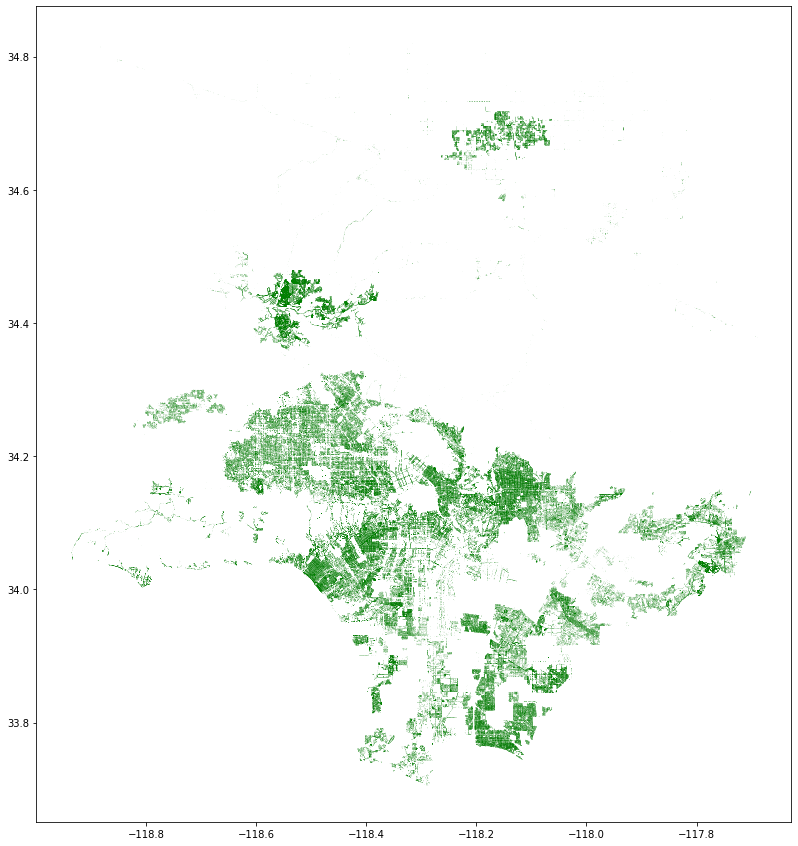

In [15]:
combineddf = geo_e6_trees.append(geo_goodtrees)
combineddf = combineddf.append(geo_minus118)
ax = combineddf.plot(figsize=(15, 15), color='green',alpha=0.1, markersize=0.01)

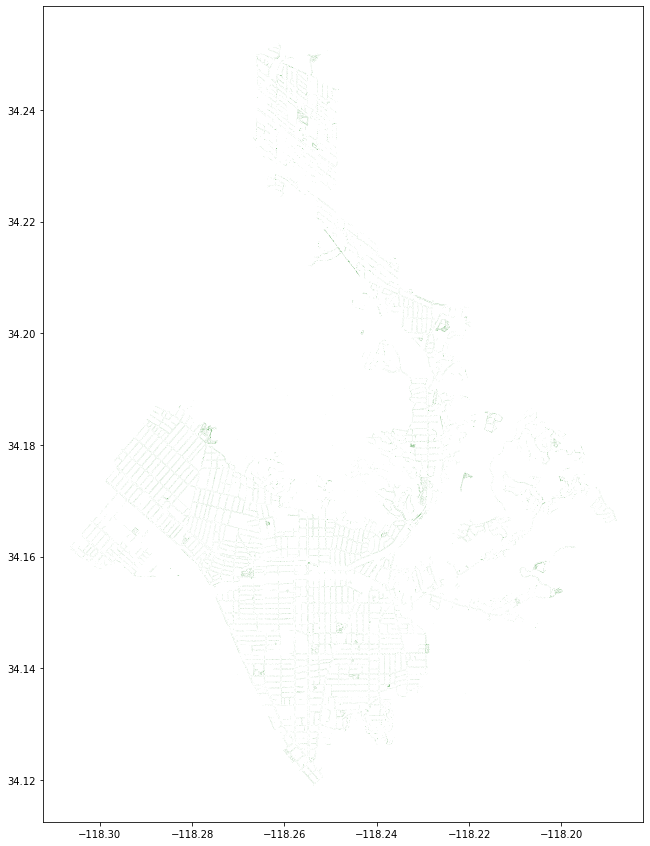

In [16]:
ax = combineddf[combineddf["city"]=="glendale"].plot(figsize=(15, 15), color='green',alpha=0.1, markersize=0.01)

In [17]:
combineddf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1435869 entries, 25239 to 1562536
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype   
---  ------      --------------    -----   
 0   city        1435869 non-null  object  
 1   geometry    1435869 non-null  geometry
 2   species     1281504 non-null  object  
 3   height      566930 non-null   object  
 4   dbh         453308 non-null   object  
 5   street      395622 non-null   object  
 6   botanical   417701 non-null   object  
 7   botanicaln  236855 non-null   object  
 8   lon         65409 non-null    float64 
 9   lat         65409 non-null    float64 
dtypes: float64(2), geometry(1), object(7)
memory usage: 120.5+ MB


In [18]:
goodcities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  49 non-null     object
 1   ok          29 non-null     object
 2   -118        8 non-null      object
 3   0           7 non-null      object
 4   -95         4 non-null      object
 5   1.00E+06    8 non-null      object
 6   125         1 non-null      object
dtypes: object(7)
memory usage: 2.8+ KB


In [19]:
"""
To check if geometry falls within LA bountry: Manual method

city_names = list(clean_trees['city'].unique())

for i in city_names:
  select_trees = clean_trees[clean_trees['city']==f'{i}']
  geo_df = gpd.GeoDataFrame(select_trees, geometry='geometry')
  ax = map_df.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
  geo_df.plot(ax=ax, color='green')
  print(f"trees in {i}")
  plt.show()

"""

'\nTo check if geometry falls within LA bountry: Manual method\n\ncity_names = list(clean_trees[\'city\'].unique())\n\nfor i in city_names:\n  select_trees = clean_trees[clean_trees[\'city\']==f\'{i}\']\n  geo_df = gpd.GeoDataFrame(select_trees, geometry=\'geometry\')\n  ax = map_df.plot(figsize=(10, 10), alpha=0.5, edgecolor=\'k\')\n  geo_df.plot(ax=ax, color=\'green\')\n  print(f"trees in {i}")\n  plt.show()\n\n'

In [20]:
geo_df = gpd.GeoDataFrame(goodtrees, geometry='geometry')
ax = map_df.plot(figsize=(15, 15), alpha=0.2,edgecolor='gray')
geo_df.plot(ax=ax, color='green',alpha=0.1, markersize=0.01)
plt.show()

NameError: ignored

In [ ]:
ax2 = geo_df.plot(figsize=(15, 15), color='green',alpha=0.1, markersize=0.01)
ctx.add_basemap(ax2,zoom=10)
ax2.set_axis_off()

In [ ]:
geo_df = geo_df.to_crs(epsg=3857)
ax2 = geo_df.plot(figsize=(15, 15), color='green',alpha=0.1, markersize=0.01)
ctx.add_basemap(ax2,zoom=10)
ax2.set_axis_off()

In [21]:
income_df = gpd.read_file("/content/drive/My Drive/Public Trees - Wes/LA median income/Median_Household_Income_by_Census_Tract.shp", encoding="utf-8")

#All the 4 files related to geospatial data should be placed in one folder.
#example: .shp, .prj, .dbf, .shx
#ty: https://www.kaggle.com/learn-forum/122966

# check data type so we can see that this is not a normal dataframe, but a GEOdataframe
income_df.info()

#downloaded map data from https://geohub.lacity.org/


income_df = income_df[['tract','B19013e1','ShapeSTAre','ShapeSTLen','geometry']]
income_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2344 entries, 0 to 2343
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    2344 non-null   int64   
 1   CT10        2344 non-null   object  
 2   OID         2344 non-null   int64   
 3   tract       2344 non-null   object  
 4   B19013e1    2344 non-null   int64   
 5   B19013Ae1   2344 non-null   int64   
 6   B19013Be1   2344 non-null   int64   
 7   B19013Ce1   2344 non-null   int64   
 8   B19013De1   2344 non-null   int64   
 9   B19013Ee1   2344 non-null   int64   
 10  B19013Fe1   2344 non-null   int64   
 11  B19013Ge1   2344 non-null   int64   
 12  B19013He1   2344 non-null   int64   
 13  B19013Ie1   2344 non-null   int64   
 14  ShapeSTAre  2344 non-null   float64 
 15  ShapeSTLen  2344 non-null   float64 
 16  geometry    2344 non-null   geometry
dtypes: float64(2), geometry(1), int64(12), object(2)
memory usage: 311.4+ KB
<class 'g

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


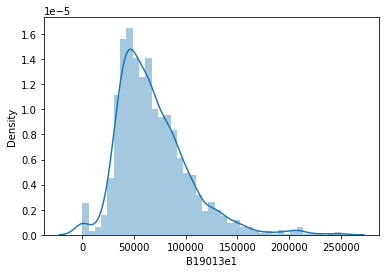

In [22]:
sns.distplot(income_df['B19013e1'])

In [ ]:
ax = income_df.plot(figsize=(10, 10),column='B19013e1', alpha=0.5, edgecolor='k')

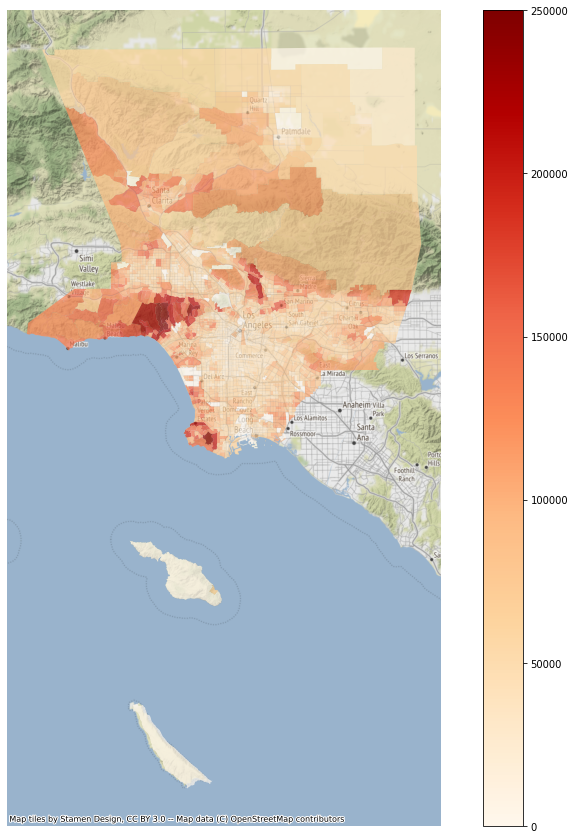

In [24]:
gdf = income_df.to_crs(epsg=3857)
ax2 = gdf.plot(figsize=(15, 15), column='B19013e1',alpha=0.7, edgecolor='None',cmap='OrRd',legend=True)
ctx.add_basemap(ax2,zoom=10)
ax2.set_axis_off()

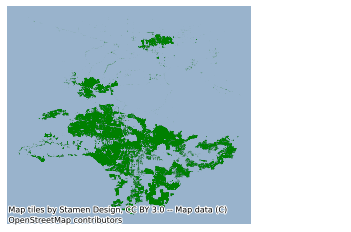

In [25]:
#gdf = income_df.to_crs(epsg=3857)
#ax2 = gdf.plot(figsize=(15, 15), column='B19013e1',alpha=0.7, edgecolor='None',cmap='OrRd',legend=True)
#ctx.add_basemap(ax2,zoom=10)
#ax2.set_axis_off()


#ax = income_df.plot(figsize=(15, 15), column='B19013e1',alpha=0.7, edgecolor='None',cmap='OrRd',legend=True)
ax = combineddf.plot(color='green',alpha=0.05, markersize=0.005)
ctx.add_basemap(ax,zoom=10)
ax.set_axis_off()
plt.show()


In [ ]:
gdf = income_df.to_crs(epsg=3857)
ax2 = gdf.plot(figsize=(15, 15), column='B19013e1',alpha=0.7, edgecolor='None',cmap='OrRd',legend=True)
ctx.add_basemap(ax2, url=ctx.providers.Stamen.TonerLite)
ax2.set_axis_off()

In [ ]:
ax2 = gdf.plot(figsize=(15, 15), column='B19013e1',alpha=0.7, edgecolor='None',cmap='OrRd',legend=True)
ax2.set_axis_off()

In [ ]:
geo_df2 = geo_df.set_crs(epsg=3857)

In [ ]:
#ax2 = gdf.plot(figsize=(15, 15), column='B19013e1',alpha=0.7, edgecolor='None',cmap='OrRd',legend=True)

geo_df = geo_df.set_crs(epsg=3857)
ax = gdf.plot(figsize=(15, 15), alpha=0.2,edgecolor='gray')
geo_df.plot(ax=ax, color='green',alpha=0.1, markersize=0.01)
plt.show()

In [ ]:
ax = map_df.plot(figsize=(15, 15), alpha=0.2,edgecolor='gray')

In [ ]:
ax = gdf.plot(figsize=(15, 15), alpha=0.2,edgecolor='gray')

In [ ]:
ax = income_df.plot(figsize=(15, 15), alpha=0.2,edgecolor='gray')
geo_df.plot(ax=ax, color='green',alpha=0.1, markersize=0.01)
plt.show()

In [ ]:
ax = income_df.plot(figsize=(15, 15), column='B19013e1',alpha=0.7, edgecolor='None',cmap='OrRd',legend=True)
combineddf.plot(ax=ax, column=combineddf.city,alpha=0.05, markersize=0.005)

plt.show()

In [ ]:
#ax = gdf.plot(column=gdf.Type, cmap=cmap, label=gdf.Type, figsize=(10,10), alpha=.5)

ax = combineddf.plot(figsize=(15, 15), column=combineddf.city,alpha=0.1, markersize=0.01)

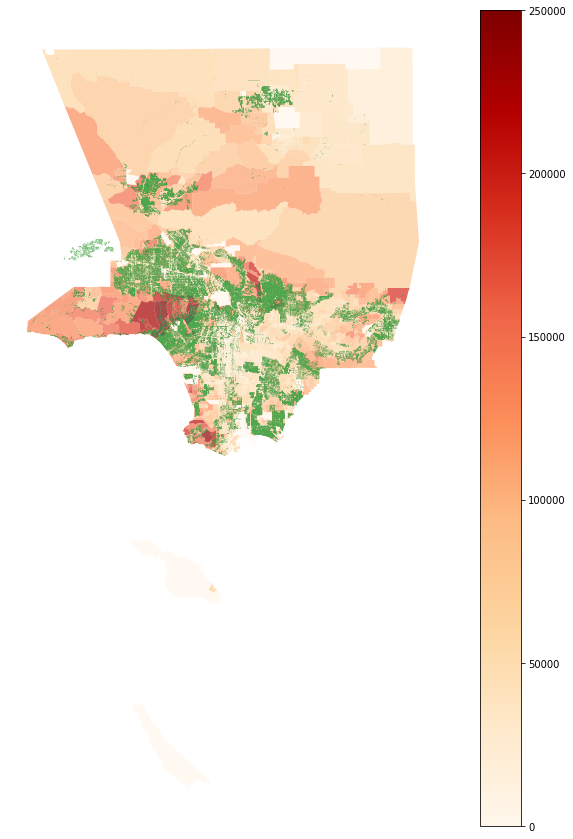

In [23]:
ax = income_df.plot(figsize=(15, 15), column='B19013e1',alpha=0.7, edgecolor='None',cmap='OrRd',legend=True)
combineddf.plot(ax=ax, color='green',alpha=0.05, markersize=0.005)
ax.set_axis_off()
plt.show()

In [ ]:
from shapely.geometry import *

p1 = Point(.5,.5)
p2 = Point(.5,1)
p3 = Point(1,1)

poly = Polygon([(0,0), (0,2), (2,2), (2,0)])

df1 = gpd.GeoSeries([p1,p2,p3])
df2 = gpd.GeoDataFrame([poly,p3], columns=['geometries'])

f = lambda x:np.sum(df1.intersects(x))
df2['geometries'].apply(f)

In [ ]:
test_points

In [ ]:
test_points = combineddf.iloc[40:50]
one_polygon = income_df['geometry'][0]
results = []

for i in combineddf['geometry']:
  results.append(i.intersects(one_polygon))

In [ ]:
test_points = combineddf.iloc[40:50]
sample_polys = income_df.iloc[100:111]
#results = []

#for i in combineddf['geometry']:
#  results.append(i.intersects(one_polygon))

In [ ]:
pointsperregion = []

for j in income_df['geometry']:
  counts = 0
  for i in combineddf['geometry']:
    result = i.intersects(j)
    if result == True:
      counts += 1
  pointsperregion.append(counts)
  print(f'done with {len(pointsperregion)} poly with {counts}')

pointsperregion

In [ ]:
"""
check here
https://egis-lacounty.hub.arcgis.com/search?categories=boundaries%2Cpolitical%2Cadministrative%2Cservices

https://censusreporter.org/data/map/?table=B19001&geo_ids=05000US06037,04000US06,01000US,860|05000US06037&primary_geo_id=05000US06037#column|B19001017,sumlev|860

In [ ]:
errorsdf = pd.DataFrame()
errors = ["alhambra","glendora","la-mirada","walnut"]
for title in errors:
  url = f"https://github.com/stiles/data/blob/master/los-angeles-street-trees/all/{title}.geojson?raw=True"
  onecitydf = gpd.read_file(url)
  onecitydf["whichcity"] = title
  onecitydf.columns = onecitydf.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
  if 'lat' in onecitydf.columns:
    onecitydf = onecitydf.drop('lat',axis=1)
  if 'lon' in onecitydf.columns:
    onecitydf = onecitydf.drop('lon',axis=1)
  if 'objectid' in onecitydf.columns:
    onecitydf = onecitydf.drop('objectid',axis=1)
  errorsdf = errorsdf.append(onecitydf)
  print(f"Done with {title}")

errorsdf = errorsdf.dropna(how='all', axis=1)

errorsdf["sidetype"] = errorsdf["sidetype"].str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
errorsdf["species"] = errorsdf["species"].str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

vacant_df = errorsdf[(errorsdf["species"] == 'vacant') | (errorsdf["species"] == 'vacant_site')]
errorsdf = errorsdf.drop(vacant_df.index, axis=0)

#keep_sidetype = ["front","side","median","lot","sub street","slop","rear","park",""]
#errorsdf = errorsdf.query("sidetype in @keep_sidetype")

errorsdf.info()

In [ ]:
errorsdf["address"] = errorsdf["address"].astype(str)
fulladd = []
for i,j,k,l in zip(errorsdf["sidetype"],errorsdf["address"],errorsdf["street"],errorsdf["whichcity"]):
  if i == 'park':
    fulladd.append(k + ", " + l + ", california")
  else:
    fulladd.append(j + " " + k + ", " + l + ", california")

len(fulladd)

In [ ]:
import numpy as np

errorsdf['fulladd'] = np.array(fulladd)

In [ ]:


errorsdf.info()

In [ ]:
%pip install geopy
from geopy.geocoders import Nominatim
from geopy.geocoders import GoogleV3

In [ ]:
from geopy.geocoders import Nominatim
gc = Nominatim(user_agent="my_geocode_app")
location = gc.geocode("ALMANSOR PARK, alhambra, california")
print((location.latitude, location.longitude))

In [ ]:
#ty: https://towardsdatascience.com/geocode-with-python-161ec1e62b89

locator = Nominatim(user_agent='myGeocoder')
from geopy.extra.rate_limiter import RateLimiter

# 1 - conveneint function to delay between geocoding calls
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
# 2- - create location column
errorsdf['location'] = errorsdf['fulladd'].apply(geocode)
# 3 - create longitude, laatitude and altitude from location column (returns tuple)
errorsdf['point'] = errorsdf['location'].apply(lambda loc: tuple(loc.point) if loc else None)
# 4 - split point column into latitude, longitude and altitude columns
errorsdf[['latitude', 'longitude', 'altitude']] = pd.DataFrame(errorsdf['point'].tolist(), index=df.index)

In [ ]:
errorsdf

In [ ]:



url = f"https://github.com/stiles/data/blob/master/los-angeles-street-trees/all/alhambra.geojson?raw=True"
arcadiadf = gpd.read_file(url)
arcadiadf['lon'] = arcadiadf['geometry'].x
arcadiadf['lat'] = arcadiadf['geometry'].y
print(arcadiadf.crs)
print(arcadiadf.info())
#arcadiadf[arcadiadf["lon"]>-117].info()

In [ ]:
arcadiadf.tail()

# intersecting geometries

In [ ]:
incometest = income_df.iloc[0:3]
income1 = income_df.iloc[0:500]
income2 = income_df.iloc[500:1000]
income3 = income_df.iloc[1000:1500]
income4 = income_df.iloc[1500:2000]
income5 = income_df.iloc[2000:2344]

In [6]:
import numpy as np

In [ ]:
pointsperregion1 = []

for j in income1['geometry']:
  counts = 0
  for i in combineddf['geometry']:
    result = i.intersects(j)
    if result == True:
      counts += 1
  pointsperregion1.append(counts)
  print(f'done with {len(pointsperregion1)} poly with {counts}')

income1['counts'] = np.array(pointsperregion1)

income1.to_csv('income1.csv')
!cp income1.csv "/content/drive/My Drive/Public Trees - Wes/"

done with 1 poly with 74
done with 2 poly with 0
done with 3 poly with 201
done with 4 poly with 719
done with 5 poly with 87
done with 6 poly with 63
done with 7 poly with 300
done with 8 poly with 339
done with 9 poly with 406
done with 10 poly with 709
done with 11 poly with 938
done with 12 poly with 576
done with 13 poly with 721
done with 14 poly with 1
done with 15 poly with 2572
done with 16 poly with 1237
done with 17 poly with 0
done with 18 poly with 0
done with 19 poly with 0
done with 20 poly with 0
done with 21 poly with 0
done with 22 poly with 0
done with 23 poly with 7
done with 24 poly with 0
done with 25 poly with 0
done with 26 poly with 376
done with 27 poly with 429
done with 28 poly with 264
done with 29 poly with 12
done with 30 poly with 206
done with 31 poly with 719
done with 32 poly with 216
done with 33 poly with 49
done with 34 poly with 0
done with 35 poly with 9
done with 36 poly with 285
done with 37 poly with 39
done with 38 poly with 36
done with 39 p

/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [ ]:
pointsperregion2 = []

for j in income2['geometry']:
  counts = 0
  for i in combineddf['geometry']:
    result = i.intersects(j)
    if result == True:
      counts += 1
  pointsperregion2.append(counts)
  print(f'done with {len(pointsperregion2)} poly with {counts}')

income2['counts'] = np.array(pointsperregion2)

income2.to_csv('income2.csv')
!cp income2.csv "/content/drive/My Drive/Public Trees - Wes/"

done with 1 poly with 582
done with 2 poly with 148
done with 3 poly with 1722
done with 4 poly with 936
done with 5 poly with 833
done with 6 poly with 383
done with 7 poly with 869
done with 8 poly with 3385
done with 9 poly with 1091
done with 10 poly with 1525
done with 11 poly with 1100
done with 12 poly with 1056
done with 13 poly with 258
done with 14 poly with 136
done with 15 poly with 51
done with 16 poly with 217
done with 17 poly with 230
done with 18 poly with 21
done with 19 poly with 3630
done with 20 poly with 856
done with 21 poly with 859
done with 22 poly with 1894
done with 23 poly with 5181
done with 24 poly with 2862
done with 25 poly with 2182
done with 26 poly with 854
done with 27 poly with 650
done with 28 poly with 587
done with 29 poly with 567
done with 30 poly with 541
done with 31 poly with 185
done with 32 poly with 213
done with 33 poly with 59
done with 34 poly with 480
done with 35 poly with 1065
done with 36 poly with 137
done with 37 poly with 1490


/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [ ]:
pointsperregion3 = []

for j in income3['geometry']:
  counts = 0
  for i in combineddf['geometry']:
    result = i.intersects(j)
    if result == True:
      counts += 1
  pointsperregion3.append(counts)
  print(f'done with {len(pointsperregion3)} poly with {counts}')

income3['counts'] = np.array(pointsperregion3)

income3.to_csv('income3.csv')
!cp income3.csv "/content/drive/My Drive/Public Trees - Wes/"

done with 1 poly with 0
done with 2 poly with 0
done with 3 poly with 918
done with 4 poly with 98
done with 5 poly with 1
done with 6 poly with 29
done with 7 poly with 850
done with 8 poly with 490
done with 9 poly with 0
done with 10 poly with 131
done with 11 poly with 79
done with 12 poly with 205
done with 13 poly with 145
done with 14 poly with 336
done with 15 poly with 0
done with 16 poly with 2076
done with 17 poly with 131
done with 18 poly with 514
done with 19 poly with 698
done with 20 poly with 0
done with 21 poly with 0
done with 22 poly with 0
done with 23 poly with 0
done with 24 poly with 0
done with 25 poly with 165
done with 26 poly with 0
done with 27 poly with 535
done with 28 poly with 903
done with 29 poly with 275
done with 30 poly with 463
done with 31 poly with 682
done with 32 poly with 53
done with 33 poly with 78
done with 34 poly with 72
done with 35 poly with 71
done with 36 poly with 252
done with 37 poly with 136
done with 38 poly with 112
done with 3

/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [ ]:
pointsperregion4 = []

for j in income4['geometry']:
  counts = 0
  for i in combineddf['geometry']:
    result = i.intersects(j)
    if result == True:
      counts += 1
  pointsperregion4.append(counts)
  print(f'done with {len(pointsperregion4)} poly with {counts}')

income4['counts'] = np.array(pointsperregion4)

income4.to_csv('income4.csv')
!cp income4.csv "/content/drive/My Drive/Public Trees - Wes/"

done with 1 poly with 469
done with 2 poly with 515
done with 3 poly with 397
done with 4 poly with 37
done with 5 poly with 428
done with 6 poly with 818
done with 7 poly with 577
done with 8 poly with 328
done with 9 poly with 784
done with 10 poly with 2305
done with 11 poly with 2135
done with 12 poly with 1043
done with 13 poly with 947
done with 14 poly with 398
done with 15 poly with 1049
done with 16 poly with 1648
done with 17 poly with 967
done with 18 poly with 1313
done with 19 poly with 434
done with 20 poly with 593
done with 21 poly with 15
done with 22 poly with 11
done with 23 poly with 8
done with 24 poly with 78
done with 25 poly with 105
done with 26 poly with 192
done with 27 poly with 9
done with 28 poly with 2074
done with 29 poly with 919
done with 30 poly with 970
done with 31 poly with 801
done with 32 poly with 1154
done with 33 poly with 667
done with 34 poly with 639
done with 35 poly with 822
done with 36 poly with 734
done with 37 poly with 413
done with 

/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [ ]:
pointsperregion5 = []

for j in income5['geometry']:
  counts = 0
  for i in combineddf['geometry']:
    result = i.intersects(j)
    if result == True:
      counts += 1
  pointsperregion5.append(counts)
  print(f'done with {len(pointsperregion5)} poly with {counts}')

income5['counts'] = np.array(pointsperregion5)

income5.to_csv('income5.csv')
!cp income5.csv "/content/drive/My Drive/Public Trees - Wes/"

done with 1 poly with 0
done with 2 poly with 0
done with 3 poly with 0
done with 4 poly with 0
done with 5 poly with 1339
done with 6 poly with 0
done with 7 poly with 0
done with 8 poly with 64
done with 9 poly with 0
done with 10 poly with 0
done with 11 poly with 0
done with 12 poly with 87
done with 13 poly with 140
done with 14 poly with 0
done with 15 poly with 0
done with 16 poly with 161
done with 17 poly with 0
done with 18 poly with 96
done with 19 poly with 0
done with 20 poly with 23
done with 21 poly with 690
done with 22 poly with 1
done with 23 poly with 0
done with 24 poly with 0
done with 25 poly with 226
done with 26 poly with 0
done with 27 poly with 538
done with 28 poly with 0
done with 29 poly with 1266
done with 30 poly with 1612
done with 31 poly with 169
done with 32 poly with 841
done with 33 poly with 346
done with 34 poly with 0
done with 35 poly with 0
done with 36 poly with 0
done with 37 poly with 0
done with 38 poly with 0
done with 39 poly with 0
done 

/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


# Analyze trees densities 

In [26]:
trees_intersect = pd.DataFrame()
for i in range(1,6):
  path = f'/content/drive/My Drive/Public Trees - Wes/income{i}.csv'
  trees = pd.read_csv(path)
  trees_intersect = trees_intersect.append(trees)

trees_intersect['geometry'] = trees_intersect['geometry'].apply(wkt.loads)
trees_intersect = gpd.GeoDataFrame(trees_intersect, geometry='geometry')

trees_intersect.set_crs(epsg=4326 , inplace=True)
trees_intersect["geometry"] = trees_intersect["geometry"].to_crs("EPSG:3857")

trees_intersect.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2344 entries, 0 to 343
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Unnamed: 0  2344 non-null   int64   
 1   B19013e1    2344 non-null   int64   
 2   ShapeSTAre  2344 non-null   float64 
 3   ShapeSTLen  2344 non-null   float64 
 4   geometry    2344 non-null   geometry
 5   counts      2344 non-null   int64   
dtypes: float64(2), geometry(1), int64(3)
memory usage: 128.2 KB


In [28]:
poverty_df = gpd.read_file("/content/drive/My Drive/Public Trees - Wes/poverty/Population_and_Poverty_by_Census_Tract.shp", encoding="utf-8")
#poverty_df.info(verbose=True, null_counts=True)
poverty_df = poverty_df[['tract','male','male18a','male18d','female','female18a','female18d','geometry','ShapeSTLen']]

poverty_df["100FPL"] = ((poverty_df["male18a"] + poverty_df["female18a"])/(poverty_df["male"] + poverty_df["female"]))*100
poverty_df["200FPL"] = ((poverty_df["male18d"] + poverty_df["female18d"])/(poverty_df["male"] + poverty_df["female"]))*100

poverty_df = poverty_df[['100FPL','200FPL','tract']]
poverty_df["Unnamed: 0"] = np.arange(len(poverty_df))


ejsm_df = gpd.read_file("/content/drive/My Drive/Public Trees - Wes/EJSM/3add6368-e61a-4279-8cc3-ad1ccb0eaadf202041-1-180j648.ou0r.shp", encoding="utf-8")

def tract_ext(int1):
  int1 = str(int1)
  return int1[4:]

ejsm_df['tract'] = ejsm_df['Tract_1'].apply(tract_ext)

ejsm_df = ejsm_df[['tract','CIscore','HazScore','HealthScor','SVscore','CCVscore']]

In [29]:
#merging poverty data to trees_intersect

trees_intersect = pd.merge(trees_intersect,poverty_df,on="Unnamed: 0")
trees_intersect = pd.merge(trees_intersect,ejsm_df,on="tract")
trees_intersect = trees_intersect.rename(columns={'B19013e1': 'median_income'})
trees_intersect.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2342 entries, 0 to 2341
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Unnamed: 0     2342 non-null   int64   
 1   median_income  2342 non-null   int64   
 2   ShapeSTAre     2342 non-null   float64 
 3   ShapeSTLen     2342 non-null   float64 
 4   geometry       2342 non-null   geometry
 5   counts         2342 non-null   int64   
 6   100FPL         2326 non-null   float64 
 7   200FPL         2326 non-null   float64 
 8   tract          2342 non-null   object  
 9   CIscore        2342 non-null   int64   
 10  HazScore       2342 non-null   int64   
 11  HealthScor     2342 non-null   int64   
 12  SVscore        2342 non-null   int64   
 13  CCVscore       2342 non-null   int64   
dtypes: float64(4), geometry(1), int64(8), object(1)
memory usage: 274.5+ KB


In [30]:
trees_intersect["area"] = trees_intersect["geometry"].area
trees_intersect["density"] = trees_intersect["counts"] / (trees_intersect["area"])
trees_intersect['log density'] = np.log(trees_intersect['density'])
trees_intersect['sqrt density'] = trees_intersect['density']**(0.5)
trees_intersect = trees_intersect.dropna(subset=['100FPL','200FPL'])
trees_intersect.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Unnamed: 0,median_income,ShapeSTAre,ShapeSTLen,geometry,counts,100FPL,200FPL,tract,CIscore,HazScore,HealthScor,SVscore,CCVscore,area,density,log density,sqrt density
0,0,50732,4.025736e+09,353933.808192,"POLYGON ((-13098645.356 4103977.932, -13098645...",74,12.639225,31.113801,911001,9,1,2,2,4,5.518756e+08,1.340882e-07,-15.824768,0.000366
2,2,75313,1.111802e+10,628603.531323,"POLYGON ((-13097322.292 4082265.425, -13097316...",201,9.248555,24.855491,930301,5,1,1,2,1,1.517472e+09,1.324571e-07,-15.837007,0.000364
3,3,63182,4.824002e+06,9050.008458,"POLYGON ((-13157879.783 4001593.671, -13157879...",719,23.794383,48.383678,573003,13,5,3,3,2,6.505064e+05,1.105293e-03,-6.807645,0.033246
4,4,65729,6.697031e+06,12308.315385,"POLYGON ((-13167759.055 3991612.896, -13167758...",87,10.761015,24.192256,297602,8,3,1,2,2,9.014198e+05,9.651441e-05,-9.245818,0.009824
5,5,53934,7.986145e+06,20183.843371,"MULTIPOLYGON (((-13167368.658 3989924.360, -13...",63,5.053599,11.830015,297601,6,1,1,2,2,1.074867e+06,5.861189e-05,-9.744573,0.007656


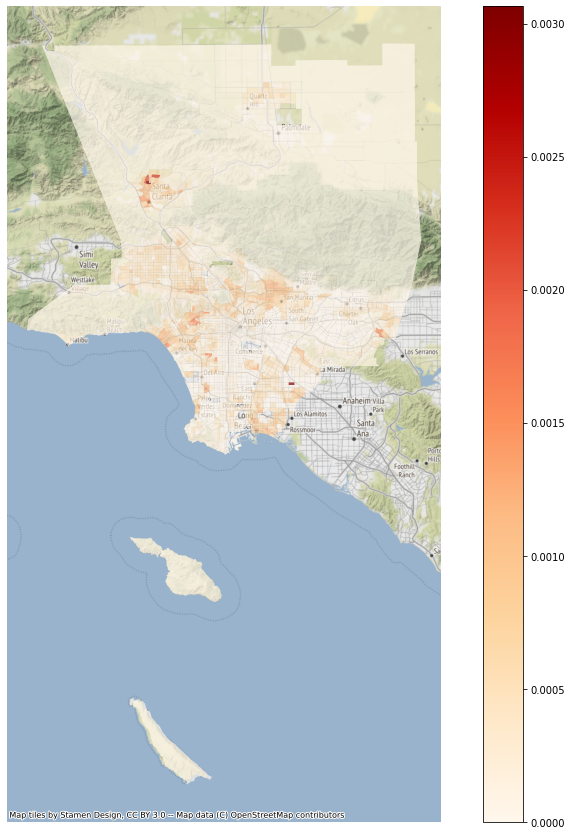

In [31]:
gdf = trees_intersect.to_crs(epsg=3857)
ax2 = gdf.plot(figsize=(15, 15), column='density',alpha=0.7, edgecolor='None',cmap='OrRd',legend=True)
ctx.add_basemap(ax2,zoom=10)
ax2.set_axis_off()

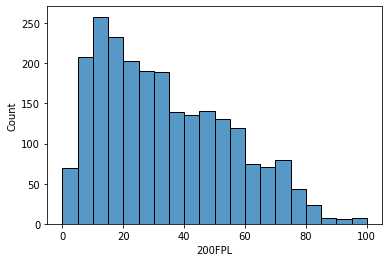

In [160]:
sns.histplot(data=trees_intersect, x='200FPL')

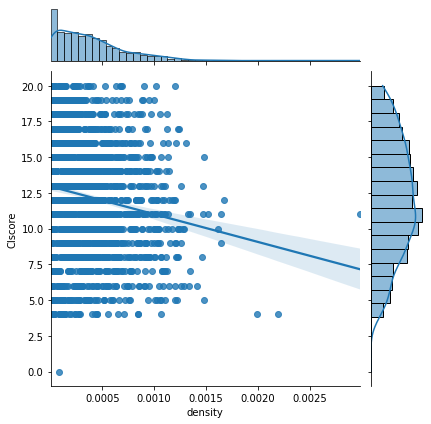

In [38]:
plotthis = trees_intersect[['counts','median_income','density','log density','sqrt density','geometry','100FPL','200FPL','CIscore','HazScore','HealthScor','SVscore','CCVscore']]
#plotthis = trees_intersect[['median_income','density','100FPL']]
#plotthis = plotthis[plotthis["counts"] > 0]
plotthis = plotthis[plotthis["density"] > 0]
plotthis = plotthis[plotthis["median_income"] > 0]
plotthis = plotthis[plotthis["median_income"] < 150000]
#plotthis = plotthis[plotthis["density"] < 0.0015]
#plotthis['density_sq'] = plotthis['density'] **2


sns.jointplot(x="density", y="CIscore", data=plotthis, kind="reg")


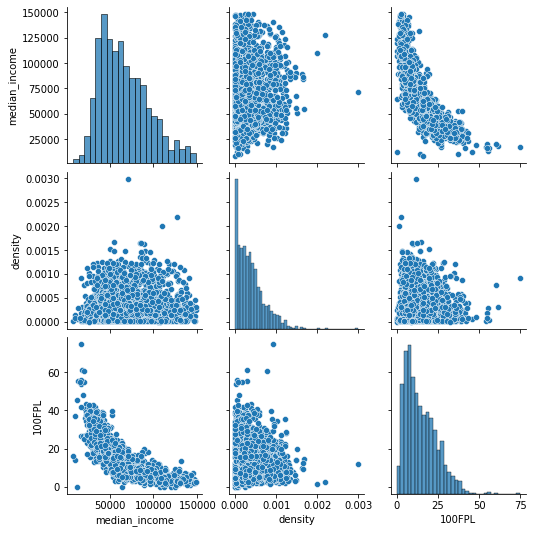

In [37]:
sns.pairplot(plotthis)

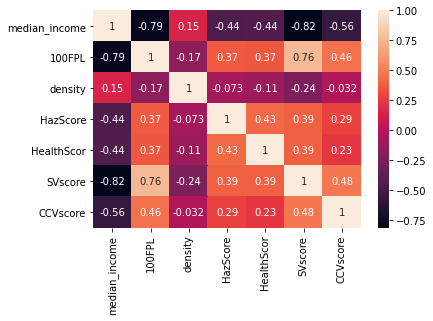

In [39]:
matrix_df = pd.DataFrame(plotthis,columns=['median_income','100FPL','density','HazScore','HealthScor','SVscore','CCVscore'])
corrMatrix = matrix_df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

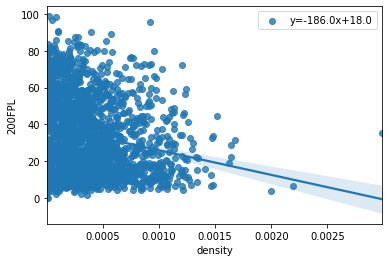

In [164]:
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(plotthis['sqrt density'],plotthis['100FPL'])

p = sns.regplot(x="density", y="200FPL", data=plotthis,label="y={0:.1f}x+{1:.1f}".format(slope, intercept)).legend(loc="best")




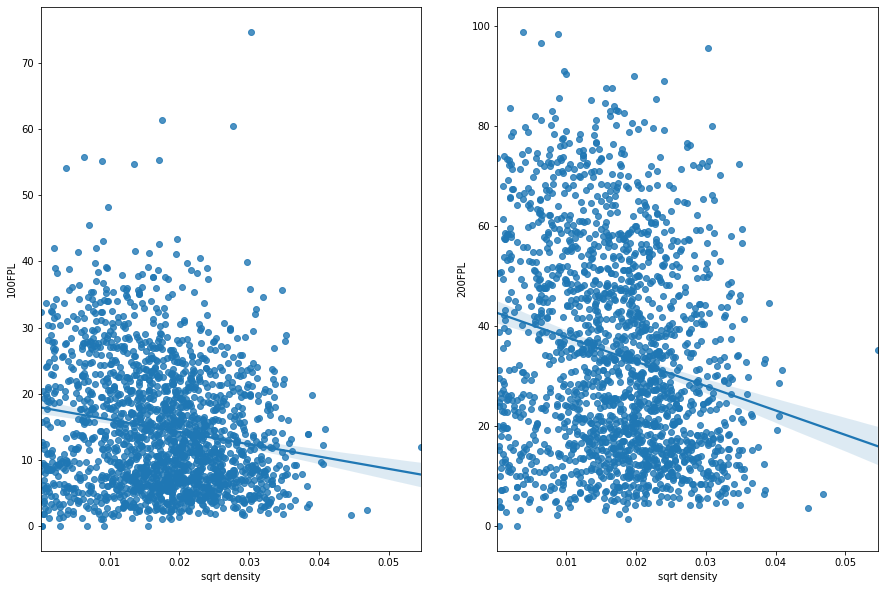

In [165]:
fig, (ax1, ax2) = plt.subplots(nrows= 1,ncols=2,figsize=(15,10)) #sharey=True)
g2 = sns.regplot(data=plotthis, x="sqrt density", y="100FPL", ax=ax1)
g1 = sns.regplot(data=plotthis, x="sqrt density", y="200FPL", ax=ax2)

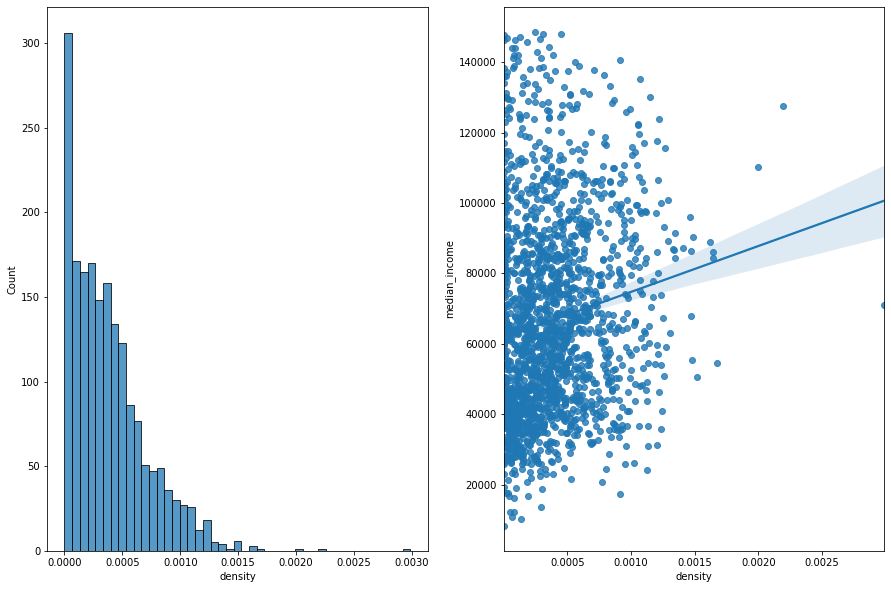

In [167]:
#fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows= 2,ncols=3,figsize=(15,10)) #sharey=True)
fig, (ax1, ax2) = plt.subplots(nrows= 1,ncols=2,figsize=(15,10)) #sharey=True)
g2 = sns.histplot(data=plotthis, x="density", ax=ax1)
g1 = sns.regplot(data=plotthis, x="density", y="median_income", ax=ax2)

In [45]:
#ty: https://datatofish.com/statsmodels-linear-regression/

import statsmodels.api as sm

X = plotthis["density"]
y = plotthis["CCVscore"]

#'HazScore','HealthScor','SVscore','CCVscore'])

X = sm.add_constant(X)

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               CCVscore   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.898
Date:                Tue, 10 Nov 2020   Prob (F-statistic):              0.168
Time:                        07:05:10   Log-Likelihood:                -3229.1
No. Observations:                1857   AIC:                             6462.
Df Residuals:                    1855   BIC:                             6473.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1282      0.049     63.396      0.000       3.031       3.225
density     -135.4983     98.354     -1.378      0.168    -328.395      57.398
==============================================================================
Omnibus:                    10106.494   Durbin-Watson:                   1.246
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              136.765
Skew:                          -0.044   Prob(JB):                     2.00e-30
Kurtosis:                       1.673   Cond. No.                     3.08e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.08e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
#cal
from scipy import stats
corr_coeff, p_val = stats.spearmanr(plotthis["density"],plotthis["CIscore"])
print('spearman' + str(corr_coeff))
print('p-value' + str(p_val))

In [ ]:
X = plotthis[["Trees / sq meter","density_sq"]]
y = plotthis["100FPL"]

X = sm.add_constant(X)

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

In [ ]:
X = plotthis["sqrt density"]
y = plotthis["Median Income $"]

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

In [ ]:
#adding aspect parameters resulted in graph being plot

ax2 = trees_intersect.plot(figsize=(15, 15), column='density',alpha=0.7, edgecolor='None',cmap='OrRd',legend=True, aspect = 1)
ctx.add_basemap(ax2, url=ctx.providers.Stamen.TonerLite)
ax2.set_axis_off()

In [ ]:
ax2 = trees_intersect.plot(figsize=(15, 15), column='100FPL',alpha=0.7, edgecolor='None',cmap='OrRd',legend=True, aspect = 1)
ctx.add_basemap(ax2, url=ctx.providers.Stamen.TonerLite)
ax2.set_axis_off()

In [ ]:
X = plotthis["sqrt density"]
y = plotthis["100FPL"]

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

In [ ]:
X = plotthis["100FPL"]
y = plotthis["Median Income $"]

X = sm.add_constant(X)

# Note the difference in argument order
model = sm.OLS(y, X)

results = model.fit()
# Print out the statistics
results.summary()


fig, ax = plt.subplots(figsize=(8,6))

ax.plot(X, y, 'o', label="data")
#ax.plot(X, results.fittedvalues, 'r--.', label="OLS")
ax.legend(loc='best')

In [ ]:
ax2 = trees_intersect2.plot(figsize=(15, 15), column='CCVscore',alpha=0.7, edgecolor='None',cmap='OrRd',legend=True, aspect = 1)
ctx.add_basemap(ax2, url=ctx.providers.Stamen.TonerLite)
ax2.set_axis_off()

In [ ]:
"""
test membership in pandas

income_df['ShapeSTLen'] = income_df['tract'].astype(str)
found = income_df[income_df['tract'].str.contains('571704')]
found